In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report)

In [3]:
train_df = pd.read_pickle("train.pkl")
test_df = pd.read_pickle("test.pkl")

In [4]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

In [5]:
# Célula 2: Pipeline e espaço de hiperparâmetros

pipeline_knn = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Espaço de busca dos hiperparâmetros do KNN
param_dist_knn = {
    'knn__n_neighbors': list(range(1, 31)),  # 1 a 30
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1=Manhattan, 2=Euclidiana
}

# Configurando a validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [6]:
# Célula 3: Rodando n_runs vezes e armazenando resultados

n_runs = 20

best_scores_knn = []          # F1 de teste em cada rodada (ou outra métrica)
best_params_knn = []          # Hiperparâmetros encontrados em cada rodada
cv_results_history = []       # Para armazenar o cv_results_ de cada rodada (médias e desvios)

for i in range(n_runs):
    print(f"\nRodada {i+1}/{n_runs}")
    
    # Ajustamos o RandomizedSearchCV
    knn_search = RandomizedSearchCV(
        estimator=pipeline_knn,
        param_distributions=param_dist_knn,
        n_iter=5,                # 20 iterações
        scoring='f1_macro',       # Métrica de interesse principal
        cv=cv,
        random_state=42 + i,      # Muda para cada rodada
        n_jobs=-1,
        verbose=1
    )
    
    knn_search.fit(X_train, y_train)
    
    # Armazena histórico completo de desempenho dessa rodada
    cv_results = pd.DataFrame(knn_search.cv_results_)
    cv_results_history.append(cv_results)
    
    # Pega o melhor modelo e avalia no conjunto de teste
    best_model_knn = knn_search.best_estimator_
    y_pred_test = best_model_knn.predict(X_test)
    
    # Métrica de teste (F1 macro, por exemplo)
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    
    best_scores_knn.append(f1_test)
    best_params_knn.append(knn_search.best_params_)
    
    print("Melhores hiperparâmetros (validação cruzada):", knn_search.best_params_)
    print("Melhor F1 (validação cruzada - média):", knn_search.best_score_)
    print("F1 no Teste:", f1_test)



Rodada 1/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 2}
Melhor F1 (validação cruzada - média): 0.9365678347450122
F1 no Teste: 0.9353732563943822

Rodada 2/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 1}
Melhor F1 (validação cruzada - média): 0.9380519351415965
F1 no Teste: 0.9395788275154459

Rodada 3/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 17}
Melhor F1 (validação cruzada - média): 0.9400942913052168
F1 no Teste: 0.9383364299167926

Rodada 4/20
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores hiperparâmetros (validação cruzada): {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors'

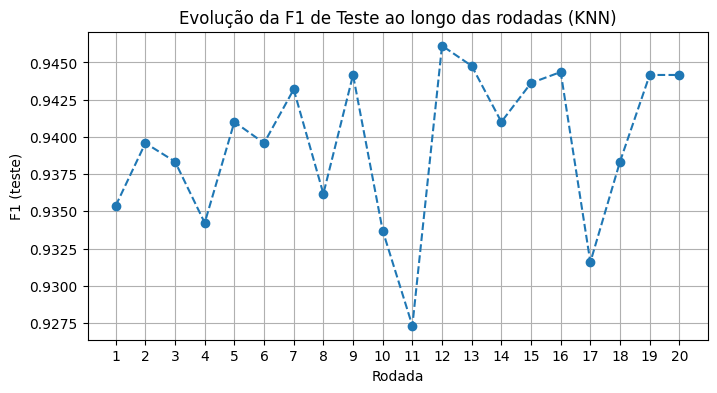

In [7]:
# Célula 4: Plotar evolução dos resultados de cada rodada (opcional)

plt.figure(figsize=(8, 4))
plt.plot(range(1, n_runs+1), best_scores_knn, marker='o', linestyle='--')
plt.title('Evolução da F1 de Teste ao longo das rodadas (KNN)')
plt.xlabel('Rodada')
plt.ylabel('F1 (teste)')
plt.xticks(range(1, n_runs+1))
plt.grid(True)
plt.show()


In [8]:
# Célula 5: Selecionar a melhor rodada entre as n_runs

best_run_index = np.argmax(best_scores_knn)
print(f"Melhor rodada: {best_run_index+1}")
print(f"F1 nessa rodada: {best_scores_knn[best_run_index]}")
print("Melhores hiperparâmetros:", best_params_knn[best_run_index])


Melhor rodada: 12
F1 nessa rodada: 0.9461202153510431
Melhores hiperparâmetros: {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 1}


In [9]:
# Célula 6: Treinamento final com os melhores hiperparâmetros

melhores_parametros = best_params_knn[best_run_index]

# Reconstruindo o Pipeline com os parâmetros ideais
best_knn_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(
        n_neighbors=melhores_parametros['knn__n_neighbors'],
        weights=melhores_parametros['knn__weights'],
        p=melhores_parametros['knn__p']
    ))
])

# Treina usando TODO o conjunto de treino (X_train, y_train)
best_knn_pipeline.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1))])

In [10]:
# Célula 7: Avaliação final no conjunto de teste

y_pred = best_knn_pipeline.predict(X_test)
y_proba = best_knn_pipeline.predict_proba(X_test)[:, 1]  # Para AUC (se for binário)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Se for binário, é possível calcular ROC
try:
    auc = roc_auc_score(y_test, y_proba)
except ValueError:
    auc = None  # Caso seja problema multiclasse ou algo que impeça o cálculo de AUC

print("\nDesempenho no Conjunto de Teste:")
print(f"Acurácia  : {acc:.4f}")
print(f"Precisão  : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
if auc is not None:
    print(f"AUC       : {auc:.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))



Desempenho no Conjunto de Teste:
Acurácia  : 0.9560
Precisão  : 0.9463
Recall    : 0.9459
F1-score  : 0.9461
AUC       : 0.9459

Matriz de Confusão:
[[1816  153]
 [ 150 4774]]

Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.92      0.92      0.92      1969
         1.0       0.97      0.97      0.97      4924

    accuracy                           0.96      6893
   macro avg       0.95      0.95      0.95      6893
weighted avg       0.96      0.96      0.96      6893



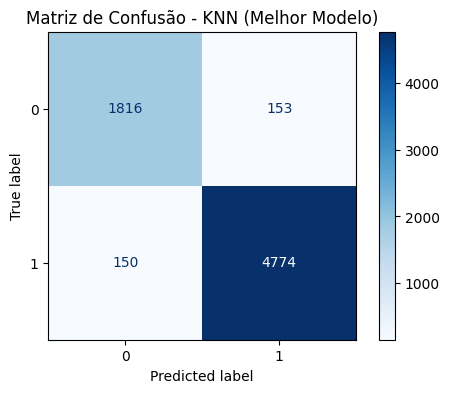

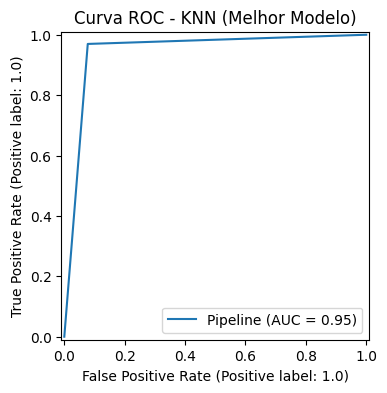

In [11]:
# Importações necessárias
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix

# Usaremos o modelo final já treinado (best_knn_pipeline), e os dados de teste X_test, y_test.

# 1) Plot da Matriz de Confusão
y_pred = best_knn_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusão - KNN (Melhor Modelo)")
plt.show()

# 2) Plot da Curva ROC (para problemas binários)
# Se for binário, podemos usar directly from_estimator:
try:
    fig_roc, ax_roc = plt.subplots(figsize=(6, 4))
    RocCurveDisplay.from_estimator(best_knn_pipeline, X_test, y_test, ax=ax_roc)
    plt.title("Curva ROC - KNN (Melhor Modelo)")
    plt.show()
except ValueError:
    print("Não foi possível gerar a Curva ROC (possivelmente é um problema multiclasse).")
